In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
#from qiskit.tools.jupyter import *
#from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import QuantumRegister, Qubit, Gate, ClassicalRegister
from qiskit.aqua.components.oracles import Oracle, TruthTableOracle
from qiskit.quantum_info import Statevector

# Transpiling stuff
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap
from qiskit.transpiler import CouplingMap, Layout


#import utils
from collections import OrderedDict

import math
import numpy as np
from sympy.combinatorics.graycode import GrayCode, bin_to_gray, gray_to_bin

# Import general libraries (needed for functions)
import time

# Import Qiskit classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

from qiskit.test.mock import FakeYorktown #, FakeCasablanca

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [2]:
number_W = 2
betas = [0.1,1]

provider = IBMQ.get_provider(hub='ibm-q-research', group='madrid-1', project='main') 
print(provider)
backends = provider.backends()
for backend in backends:
    print(backend.name())
    
backend = provider.backends(name = 'ibmq_casablanca')[0]
#backend = provider.backends(name = 'ibmq_casablanca')[0]
properties = backend.properties() 
coupling_map = backend.configuration().coupling_map

<AccountProvider for IBMQ(hub='ibm-q-research', group='madrid-1', project='main')>
ibmq_qasm_simulator
ibmqx2
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_casablanca
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_jakarta
ibmq_manila
ibm_lagos


First thing we need is to load the differences of energies, that I call deltas

In [3]:
import json
with open('delta_energies_glycylglycine_1_hardware.json') as json_file:
    data = json.load(json_file)

deltas_dictionary = data['deltas']
deltas_dictionary = OrderedDict(sorted(deltas_dictionary.items()))
print(len(deltas_dictionary))
deltas = {}
for (key,value) in deltas_dictionary.items():
    deltas[key[:3]] = value
    #print(key,value)
print('corrected ------------------')
for (key,value) in deltas.items():
    print(key, value)

16
corrected ------------------
000 0.27042123529724904
001 26.032737333542684
010 0.24282032166763656
011 -26.032737333542684
100 -0.27042123529724904
101 26.00513641991307
110 -0.24282032166763656
111 -26.00513641991307


Then, we need to compute the acceptance probabilities (and amplitudes) from such deltas

In [4]:
def calculate_angles(deltas_dictionary, beta = 1, scaling_factor = 1000):
    
    exact_angles = {}

    for key in deltas_dictionary.keys():

        if deltas_dictionary[key] >= 0:

            if scaling_factor == -1:
                probability = math.exp(-beta * deltas_dictionary[key])
            else:
                probability = math.exp(-scaling_factor* beta * deltas_dictionary[key])
        else: 
            probability = 1
        # Instead of encoding the angle corresponding to the probability, we will encode the angle theta such that sin^2(pi/2 - theta) = probability.
        # That way 1 -> 000, but if probability is 0 there is some small probability of acceptance

        # Instead of probability save angles so rotations are easier to perform afterwards sqrt(p) = sin(pi/2-theta/2).
        # The theta/2 is because if you input theta, qiskits rotates theta/2. Also normalised (divided between pi the result)
        exact_angles[key] = math.pi - 2 * math.asin(math.sqrt(probability))


    # Order angles by key
    exact_angles = OrderedDict(sorted(exact_angles.items()))

    return exact_angles

The hard part to compute is the oracle that performs the coin rotations. The dumb way of doing it is

In [5]:
angles = calculate_angles(deltas_dictionary = deltas, beta = 1, scaling_factor = 1)
print(angles)

def hardware_GG_1_coin_flip_inefficient(circuit,coin,move_id,angle_psi,angle_phi,angles,inverse, iteration,beta):
    ''' Applies the controlled rotation to the target coin. Substitutes the oracle'''
    if inverse == 1:
        circuit.x(coin)
    
    if angles['111'] > .01:
        circuit.mcrx(theta = -inverse * angles['111'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['110'] > .01:
        circuit.mcrx(theta = -inverse * angles['110'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_psi)
    
    if angles['100'] > .01:
        circuit.mcrx(theta = -inverse * angles['100'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['101'] > .01:
        circuit.mcrx(theta = -inverse * angles['101'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_phi)
    
    if angles['001'] > .01:
        circuit.mcrx(theta = -inverse * angles['001'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['000'] > .01:
        circuit.mcrx(theta = -inverse * angles['000'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_psi)
    
    if angles['010'] > .01:
        circuit.mcrx(theta = -inverse * angles['010'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['011'] > .01:
        circuit.mcrx(theta = -inverse * angles['011'], q_controls = [angle_phi[0],angle_psi[0],move_id[0]], q_target = coin[0], use_basis_gates=False) 
    circuit.x(angle_phi)
    
    if inverse == -1:
        circuit.x(coin)

OrderedDict([('000', 1.0167694425474774), ('001', 3.1415882063258103), ('010', 0.9657199604737436), ('011', 0.0), ('100', 0.0), ('101', 3.1415881445260845), ('110', 0.0), ('111', 0.0)])


But this is ineficient! We can make it more efficient by

In [6]:
angles = calculate_angles(deltas_dictionary = deltas, beta = .1)
print(angles)
def hardware_GG_1_coin_flip(circuit,coin,move_id,angle_psi,angle_phi,angles,inv,iteration,beta):
    '''Warning! This only works for GG 1 in hardware mode. Do not use elsewhere!'''
    # First we have to identify the non-zero angles. For the rest we accept with probability 1
    circuit.x(coin)
    '''
    Since the angles from 001 and 101 ~= 2.59; and those from 010 and 000 ~= 0.32 (when beta = .1, 
    but they'll always be similar nevertheless), we will perform those rotations together
    '''
    non_zero_angles = {}
    non_zero_angles['0x0'] = (angles['000']+angles['010'])/2
    non_zero_angles['x01'] = (angles['001']+angles['101'])/2
    
    # Let us first perform the first
    circuit.x(angle_phi)
    circuit.x(move_id)
    circuit.mcrx(theta = -inv*non_zero_angles['0x0'],
                 q_controls = [move_id[0],angle_phi[0]], q_target = coin[0], use_basis_gates=True)
    circuit.x(angle_phi)
    circuit.x(move_id)
    
    # Let us perform the second
    circuit.x(angle_psi)
    circuit.mcrx(theta = -inv*non_zero_angles['x01'],
                 q_controls = [move_id[0],angle_psi[0]], q_target = coin[0], use_basis_gates=True)
    circuit.x(angle_psi)

OrderedDict([('000', 3.1415899688173488), ('001', 3.141592653589793), ('010', 3.141581981395924), ('011', 0.0), ('100', 0.0), ('101', 3.141592653589793), ('110', 0.0), ('111', 0.0)])


Then we define one step

In [7]:
def W_step(qc,coin,move_id,angle_psi,angle_phi,angles,iteration,beta): 
    # Perform the preparation of possible moves----
    qc.h(move_id)

    # Prepare the Boltzmann coin ------------------
    hardware_GG_1_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inv = 1,iteration=iteration,beta = beta)
    
    # Perform move ---------------------------------
    # For the second angle
    qc.ccx(coin,move_id,angle_psi)

    # For the first angle
    qc.x(move_id)
    qc.ccx(coin,move_id,angle_phi)
    qc.x(move_id)

    if iteration == 0:
        # Unprepare the Boltzmann coin--------------------
        hardware_GG_1_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inv = -1,iteration=0,beta = beta)

        # Perform the preparation of possible moves ----
        qc.h(move_id)

        #Reflection -------------------------------------
        qc.x(move_id)
        qc.x(coin)

        # Perform a multicontrolled Z
        qc.cz(move_id,coin)

        qc.x(move_id)
        qc.x(coin)

And the full circuit

In [8]:
def generate_circ(betas = [0.1,1]):
    
    move_id  = QuantumRegister(1)
    angle_phi = QuantumRegister(1)
    angle_psi = QuantumRegister(1)
    coin = QuantumRegister(1)
    c_reg = ClassicalRegister(2)
    qc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)

    #Circuit ----------
    qc.h(angle_phi)
    qc.h(angle_psi)
    for i,beta in zip(range(number_W),betas):
        angles = calculate_angles(deltas_dictionary = deltas, beta = beta)
        W_step(qc,coin,move_id,angle_psi,angle_phi,angles,i,beta = beta)

    # Measure
    qc.measure(angle_phi[0], c_reg[1])
    qc.measure(angle_psi[0], c_reg[0])

    # Transpiling -------

    #layout = {5: angle_phi[0], 6: angle_psi[0], 4: move_id[0], 5: coin[0]}
    layout = {2: angle_psi[0], 3: angle_phi[0], 1: coin[0], 0: move_id[0]} 
    qc = transpile(qc, backend = backend, optimization_level=3, 
                   initial_layout=layout, basis_gates = ['u1', 'u2', 'u3', 'cx'], routing_method = 'lookahead')
    print('After optimization--------')
    print('gates = ', qc.count_ops())
    print('depth = ', qc.depth())
    return qc

We can define a noiseless execution

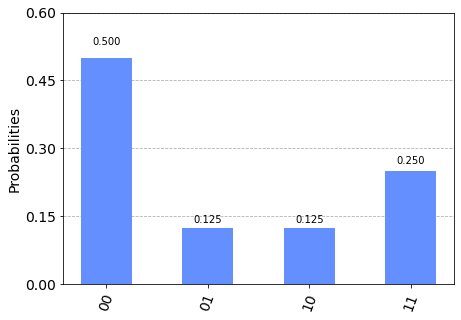

In [9]:
def exe_noiseless(betas = betas):
    
    move_id  = QuantumRegister(1, name = 'move_id')
    angle_phi = QuantumRegister(1, name = 'angle_phi')
    angle_psi = QuantumRegister(1, name = 'angle_psi')
    coin = QuantumRegister(1, name = 'coin')
    c_reg = ClassicalRegister(4)
    aerqc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)

    #Circuit ----------
    aerqc.h(angle_phi)
    aerqc.h(angle_psi)
    for i,beta in zip(range(number_W),betas):
        angles = calculate_angles(deltas_dictionary = deltas, beta = beta)
        W_step(aerqc,coin,move_id,angle_psi,angle_phi,angles,i,beta)

    # Measure
    aerbackend = Aer.get_backend('statevector_simulator')
    backend_options = {"method" : "statevector"}
    experiment = execute(aerqc, aerbackend, backend_options=backend_options)
    state_vector = Statevector(experiment.result().get_statevector(aerqc))

    probabilities = state_vector.probabilities([3,2])
    noiseless_counts = {}
    noiseless_counts['00'] = float(probabilities[0])
    noiseless_counts['01'] = float(probabilities[1])
    noiseless_counts['10'] = float(probabilities[2])
    noiseless_counts['11'] = float(probabilities[3])

    return noiseless_counts
    #plot_histogram(noiseless_counts)
noiseless_counts = exe_noiseless()
plot_histogram(noiseless_counts)

We can run it in real hardware using

In [ ]:
#beta = 1e-10
qc = generate_circ(betas = betas)
n_iterations = 1

for i in range(n_iterations):
    #print('iteration =',i)
    counts= execute(qc, backend, shots=8192).result().get_counts()
    raw_counts = [counts[i] for i in ['00','01','10','11']]
    
noiseless = exe_noiseless(betas = betas)
noiseless_count = [noiseless[i] for i in ['00','01','10','11']]

#print(np.average(raw_counts['beta='+str(beta)]))
#print(np.std(raw_counts['beta='+str(beta)]))
plot = plot_histogram([raw_counts,noiseless_counts], legend=['raw','noiseless'], color = ['red','green'])

After optimization--------
gates =  OrderedDict([('cx', 105), ('u3', 65), ('u2', 31), ('u1', 19), ('measure', 2), ('barrier', 1)])
depth =  174


and run it with

In [ ]:
plot